<center> <h1> <span style="color:black"> [BLOG POST 2]- Boost your model performance with Machine/Deep Learning</h1> </center> 
<center> <h2> <span style="color:red">Machine Learning in Actuarials  </h1> </center>
<center> <h3> <span style="color:black"> Author: Marino San Lorenzo </h1> </center>

# Agenda


+ [1 Regression Trees](#one)
    + [1.1 No optimization](#one-one)
    + [1.2 Random Search - Scikit Learn](#one-two)
    + [1.3 Halving Random Search - Scikit Learn](#one-three)
    + [1.4 Random Search - Customed](#one-four)
    + [1.5 Bayesian - Mango](#one-five)
+ [2 Random Forest](#two)
    + [2.1 No optimization](#two-one)
    + [2.2 Random Search - Scikit Learn](#two-two)
    + [2.3 Halving Random Search - Scikit Learn](#two-three)
    + [2.4 Bayesian - Mango](#two-four)
    + [2.5 Random Search - Customed](#two-five)
+ [3 Gradient Boosting ](#three)
    + [3.1 No optimization](#three-one)
    + [3.2 Random Search - Scikit Learn](#three-two)
    + [3.3 Halving Random Search - Scikit Learn](#three-three)
    + [3.4 Bayesian - Mango](#three-four)
    + [3.5 Random Search - Customed](#three-five)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from src.constants import Constants, params, Constants2, params_blog_2, params_blog_3, ConstantsBlog3
from typing import *
from src.styling import *
from src.utils import *
from src.plots import *
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import warnings
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from collections import defaultdict
from matplotlib import cm
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from dtreeviz.trees import dtreeviz
from sklearn.experimental import enable_halving_search_cv # get the experimental version of halving search working
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV
from functools import partial
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from mango import Tuner
import time
from mango import scheduler
from mango import MetaTuner

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.float_format','{:,.4f}'.format)
plt.style.use('ggplot')
pd.set_option("display.precision", 4)

In [3]:
RANDOM_STATE = params_blog_2.get(Constants2.RANDOM_STATE)
TEST_SIZE = params_blog_2.get(Constants2.TEST_SIZE)
VAL_SIZE = params_blog_2.get(Constants2.VAL_SIZE_FROM_TRAIN_SIZE)
N_ITER_SKLEARN_HYPEROPT = params_blog_2.get(Constants2.N_ITER_SKLEARN_HYPEROPT)
N_ITER= N_ITER_SKLEARN_HYPEROPT
NB_MAX_ERRORS_FOR_RERUNNING_OPTIMIZATION = 10
N_JOBS_MANGO_PARALLEL = params_blog_2.get(Constants2.N_JOBS_MANGO_PARALLEL)

In [4]:
PATH_TO_DATA = params_blog_3.get(ConstantsBlog3.PATH_TO_DATA)
nb_claims_name, claim_amount_name = params_blog_3.get(ConstantsBlog3.NB_CLAIMS), params_blog_3.get(ConstantsBlog3.CLAIM_AMOUNT)
claim_frequency_name = params_blog_3.get(ConstantsBlog3.CLAIM_FREQUENCY)
exposure_name = params_blog_3.get(ConstantsBlog3.EXPOSURE_NAME)

In [5]:
df_freq = pd.read_pickle(os.path.join(PATH_TO_DATA, params_blog_3.get(ConstantsBlog3.DATASET_FREQ_NAME)))
df_sev = pd.read_pickle(os.path.join(PATH_TO_DATA, params_blog_3.get(ConstantsBlog3.DATASET_SEV_NAME)))

In [6]:
nb_claims, claim_amount = df_freq[nb_claims_name], df_freq[claim_amount_name]
X = df_freq.drop(columns=[claim_amount_name, claim_frequency_name])

In [7]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, nb_claims, 
                                                    test_size=TEST_SIZE, 
                                                   random_state=RANDOM_STATE,
                                                    stratify=X[nb_claims_name])


In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, 
                                                    test_size=VAL_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                   stratify=x_train_val[nb_claims_name])

In [9]:
exp_train, exp_val, exp_test = x_train[exposure_name], x_val[exposure_name], x_test[exposure_name]

In [10]:
x_train = x_train.drop(columns=[nb_claims_name, exposure_name])
x_val = x_val.drop(columns=[nb_claims_name, exposure_name])
x_test = x_test.drop(columns=[nb_claims_name, exposure_name])

# 1. Modelling <a name="one"></a>

For each policyholder $i$, we can identify the 

- $N_{i}$, the number of claims during the period/exposure $d_{i}$ (the duration over which the contract is force)
- $L_{i}$, the aggregate loss related to $N_{i}$ claims

The pure premium or risk premium is often denoted as $\pi_{i}$ and broken down as follow:

$\pi_{i}$ = $\mathbb{E}[\frac{N_{i}}{d_{i}}]. \mathbb{E}[\frac{L_{i}}{N_{i}}|N_{i} > 0] = \underbrace{\mathbb{E}[F_{i}]}_\text{frequency}.\underbrace{\mathbb{E}[Sev_{i}]}_\text{severity}$
***

Let set $\mathbf{x_{i}} = (x_{i1}, \cdots , x_{ip})'$

$\mathbb{E}[N_{i} | \mathbf{x_{i}}] = d_{i} exp(\beta_{0} + \sum_{j=1}^{p}(\beta_{j}x_{ij})) $

$N_{i} \sim Poi(d_{i} exp(\beta_{0} + \sum_{j=1}^{p}(\beta_{j}x_{ij})) $

***

The score of the linear predictor is defined as follow:
    
$score_{i} = \beta_{0} + \sum_{j=1}^{p}(\beta_{j}x_{ij})$

The expected claim frequency for policyholder $i$ is: $d_{i}exp(score_{i})$

$\hat{\beta_{0}}, \hat{\beta_{1}}, \cdots, \hat{\beta_{p}}$  are the estimates of the regression coefficients $\beta_{0}, \beta_{1}, \cdots, \beta_{p} $

$\hat{\lambda_{i}} = d_{i}exp(\hat{score_{i}})$

$\hat{\lambda_{i}} = d_{i}exp(\hat{\beta_{0}} + \sum_{j=1}^{p}(\hat{\beta_{j}}x_{ij}))$

is the predicted number of claims for policyholder $i$

## 1 Regression Tree <a name="one"></a>

In [125]:
scores_by_depth_tree = defaultdict(list)
nb_instances = 1_000
idx_to_keep = list(x_train.sample(nb_instances).index)
idx_to_keep_test = list(x_test.sample(nb_instances).index)
for depth_tree in tqdm(range(1, 40)):
    deep_tree = DecisionTreeRegressor(max_depth=depth_tree, criterion='poisson', random_state=RANDOM_STATE, ccp_alpha=0)
    deep_tree.fit(x_train.loc[idx_to_keep,:], y_train[idx_to_keep])
    y_pred_train = deep_tree.predict(x_train.loc[idx_to_keep,:])
    y_pred_test = deep_tree.predict(x_test.loc[idx_to_keep_test,:])
    score_train = mean_poisson_deviance(y_train[idx_to_keep], y_pred_train, sample_weight=exp_train[idx_to_keep])
    score_test = mean_poisson_deviance(y_test[idx_to_keep_test], y_pred_test, sample_weight=exp_test[idx_to_keep_test])
    scores_by_depth_tree['depth_tree'].append(depth_tree)
    scores_by_depth_tree['score_train'].append(score_train)
    scores_by_depth_tree['score_test'].append(score_test)

 ... (more hidden) ...


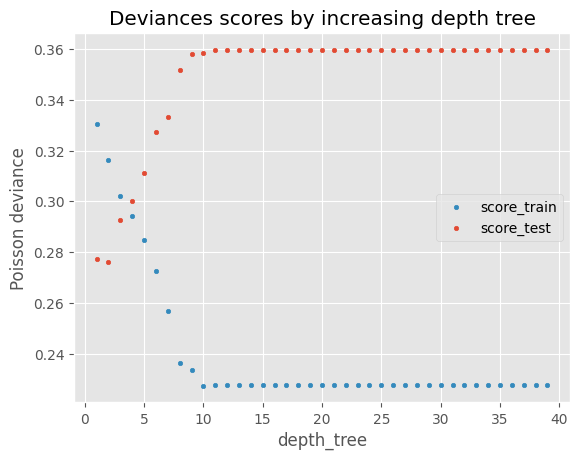

In [126]:
scores_by_depth_tree_df = pd.DataFrame(scores_by_depth_tree)
scores_by_depth_tree_df.plot(x='depth_tree', y=['score_train'], \
                                      kind='scatter',
                                      title='Deviances scores by increasing depth tree',
                                       label='score_train',
                           s=10
                                     )
plt.scatter(scores_by_depth_tree_df.depth_tree, scores_by_depth_tree_df.score_test, label='score_test', s=10)
plt.ylabel('Poisson deviance')
plt.legend()
plt.show()

### 1.1 Regression Tree - No optimization <a name="one-one"></a>

In [13]:
logging_optimizer_decorator_factory = LoggingOptimizerScikitLearn()

In [14]:
DecisionTreeRegressorLogger = logging_optimizer_decorator_factory(DecisionTreeRegressor)

In [15]:
poisson_tree_params = {'criterion':'poisson','max_depth':3, 'ccp_alpha':0, 'splitter': 'best', 'max_features':'auto', 
                      'random_state':RANDOM_STATE}
poisson_tree, results = DecisionTreeRegressorLogger('reg_tree_without_opt',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                    False,
                                     **poisson_tree_params)

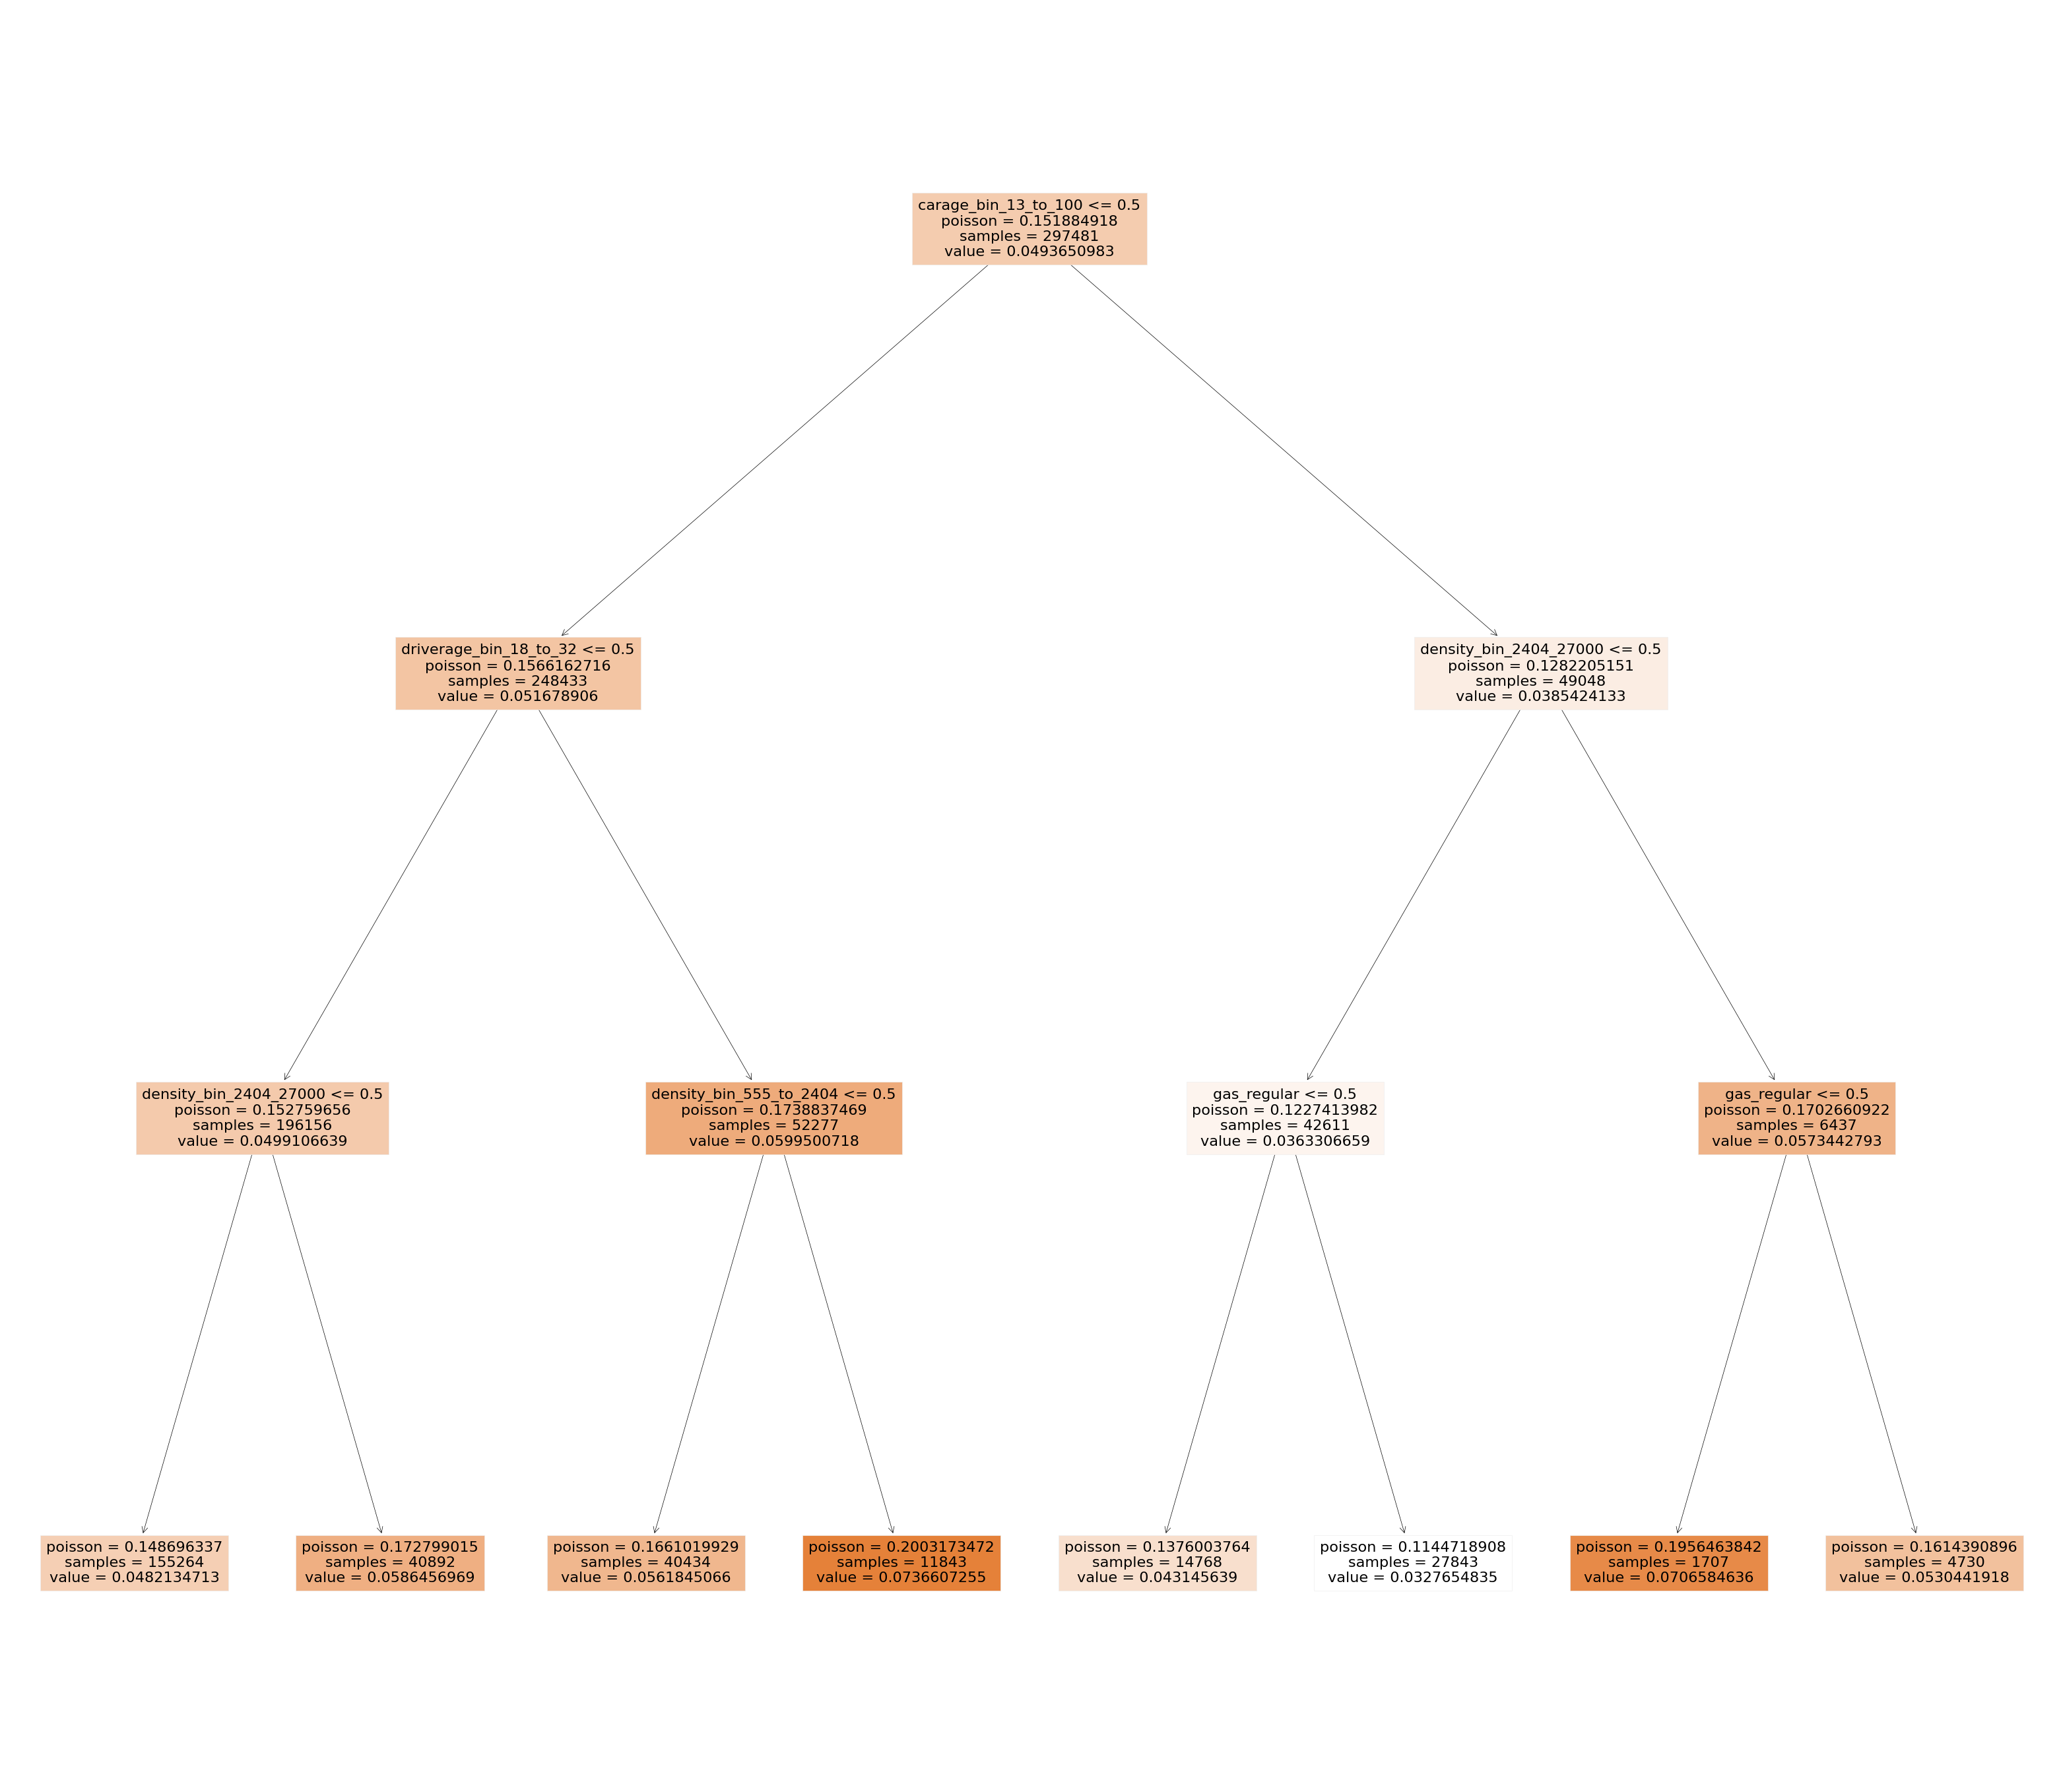

In [17]:
fig = plt.figure(figsize=(40,35))
_=tree.plot_tree(poisson_tree, 
                   feature_names=x_train.columns,  
                   filled=True,
                precision=10)

In [18]:
print(tree.export_text(poisson_tree))

|--- feature_34 <= 0.50
|   |--- feature_27 <= 0.50
|   |   |--- feature_38 <= 0.50
|   |   |   |--- value: [0.05]
|   |   |--- feature_38 >  0.50
|   |   |   |--- value: [0.06]
|   |--- feature_27 >  0.50
|   |   |--- feature_37 <= 0.50
|   |   |   |--- value: [0.06]
|   |   |--- feature_37 >  0.50
|   |   |   |--- value: [0.07]
|--- feature_34 >  0.50
|   |--- feature_38 <= 0.50
|   |   |--- feature_17 <= 0.50
|   |   |   |--- value: [0.04]
|   |   |--- feature_17 >  0.50
|   |   |   |--- value: [0.03]
|   |--- feature_38 >  0.50
|   |   |--- feature_17 <= 0.50
|   |   |   |--- value: [0.07]
|   |   |--- feature_17 >  0.50
|   |   |   |--- value: [0.05]



In [19]:
def plot_feature_importance_for_tree_based_methods(tree:sklearn.tree) -> None:
    feature_importances = {}
    for feature_name, feature_importance in zip(tree.feature_names_in_, tree.feature_importances_):
        if feature_importance>0:
            feature_importances[feature_name] = feature_importance
    sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item : item[1], reverse=False))
    plt.barh(list(sorted_feature_importances.keys()), list(sorted_feature_importances.values()))
    plt.xlabel('Sum of reduced variance induced by a set of feature splits')
    plt.title('Features importance')

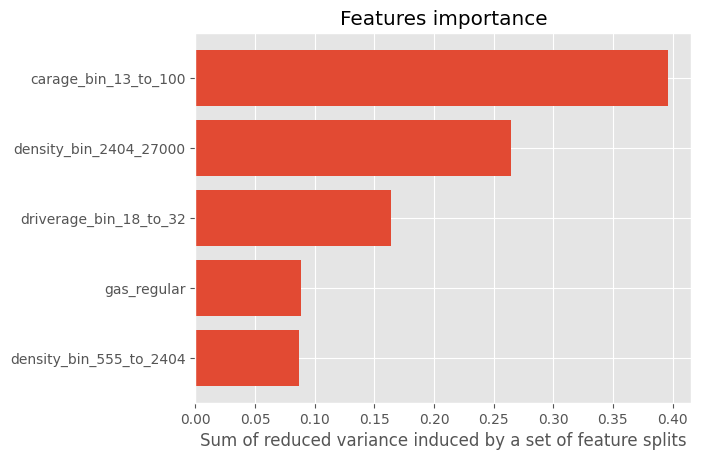

In [20]:
plot_feature_importance_for_tree_based_methods(poisson_tree)

- Here, we see which splits of bin variables contributed the most to the reduction of the initial deviance 
- The bin `carage_bin_13_to_100` is deemed to be the most important

Now, we will perform the same analysis but instead of choosing the default hyperparameter values, we randomnly search the best `max_depth` and `ccp_alpha` hyperparameter.

We will try to do it using

1. the built-in Scikit learn optimizers for random search and halving random search
2. the mango bayesian optimizer

### 1.2 Regression Tree - Random Search - Scikit Learn <a name="one-two"></a>

toy_grid = {'hyperparameter_1': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1],
            'hyperparameter_2': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1],
            ...
            'hyperparameter_10': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1],
           }


In [21]:
n_hyperparameters = 4
nb_different_hyp_value = 10
n_hyperparameters_x = [i  for i in range(1, n_hyperparameters +1)]
nb_combinations = np.cumprod([nb_different_hyp_value*i  for i in range(1, n_hyperparameters +1)])

In [22]:
n_hyperparameters = 4
nb_different_hyp_value2 = 20
n_hyperparameters_x2 = [i  for i in range(1, n_hyperparameters +1)]
nb_combinations2 = np.cumprod([nb_different_hyp_value2*i  for i in range(1, n_hyperparameters +1)])

In [23]:
nb_combinations

array([    10,    200,   6000, 240000])

In [24]:
coordinates = ([1, 2, 3, 4], np.array([    10,    200,   6000, 240000]))

In [25]:
list(zip(*coordinates))

[(1, 10), (2, 200), (3, 6000), (4, 240000)]

In [26]:
for x, y in list(zip(*coordinates)):
    print(x,y)

1 10
2 200
3 6000
4 240000


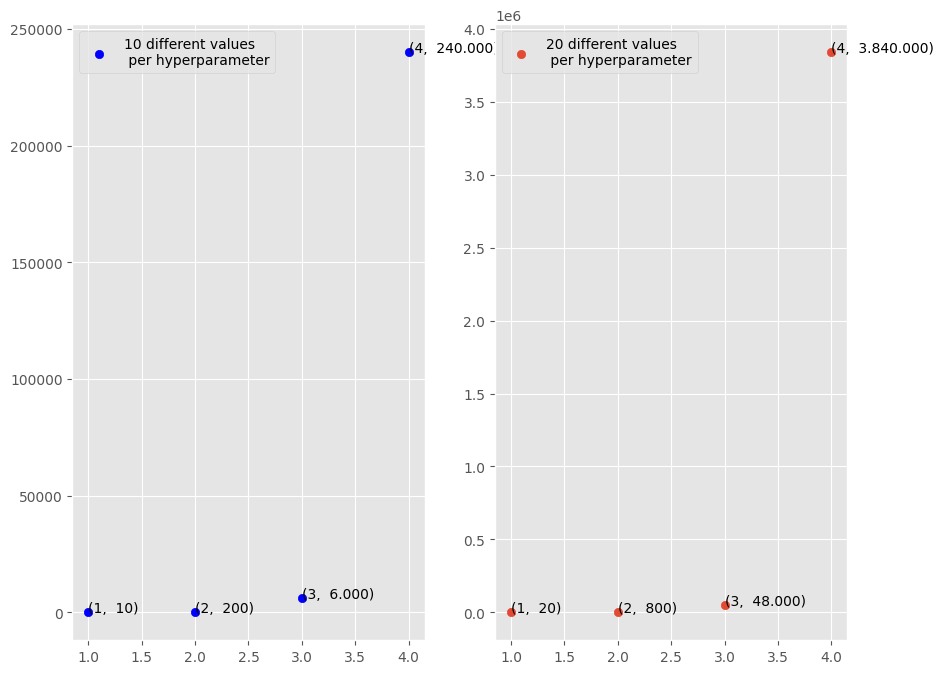

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10,8))
ax1, ax2 =ax
ax1.scatter(n_hyperparameters_x, nb_combinations, label=f'{nb_different_hyp_value} different values\n per hyperparameter', color='blue')
ax2.scatter(n_hyperparameters_x2, nb_combinations2, label=f'{nb_different_hyp_value2} different values\n per hyperparameter')
ax1.ticklabel_format(style='plain')
# ax2.ticklabel_format(style='plain')
for axe, coordinates in zip([ax1, ax2], [(n_hyperparameters_x, nb_combinations), (n_hyperparameters_x2, nb_combinations2)]):
    for x,y in list(zip(*coordinates)):
        y_formatted = f'{y:,d}'.replace(',','.')
        axe.annotate(f'({x},  {y_formatted})',xy=(x,y))
    
# ax.title('Number of combinations of hyperparameters w.r.t the number of hyperparameters to tune')
# ax.set_ylabel('Number of combinations of hyperparameters')
# ax.set_xlabel('Number of hyperparameters'
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
plt.show()

In [28]:
list(zip([1,2], [3,4]))

[(1, 3), (2, 4)]

In [29]:
step = 0.01
param_grid_reg_tree = {'max_depth': [7],
               'random_state':[RANDOM_STATE],
              'criterion': ['poisson'],
              'ccp_alpha': list(np.arange(0,1+step, step)),
#              'splitter': ['best'], 
              'max_features':['auto']}
meta_hyperparams = {'estimator':DecisionTreeRegressor(), 
                    'param_distributions':param_grid_reg_tree,
                    'n_iter':N_ITER_SKLEARN_HYPEROPT,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True
                   }

In [30]:
RandomSearchLogger = logging_optimizer_decorator_factory(RandomizedSearchCV)

In [31]:
reg_tree_opt_rs_scikit, results = RandomSearchLogger('reg_tree_opt_rs_scikit',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     True,
                                    **meta_hyperparams)

In [32]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.3024,0.3012,NaN,0.0057,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0, 'splitter': 'best', 'max_features': 'auto', 'random_state': 42}"
reg_tree_opt_rs_scikit,0.3038,0.3029,0.0035,0.5705,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"


### 1.3 Regression Tree - Halving Random Search - Scikit Learn <a name="one-three"></a>

In [33]:
meta_hyperparams = {'estimator':DecisionTreeRegressor(), 
                    'param_distributions':param_grid_reg_tree,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True}

In [34]:
HalvingRandomSearchLogger = logging_optimizer_decorator_factory(HalvingRandomSearchCV)

In [35]:
i, has_search_successfully_ran = 0, False
while i <NB_MAX_ERRORS_FOR_RERUNNING_OPTIMIZATION and not(has_search_successfully_ran):
    try:
        reg_tree_opt_halving_rs_scikit, results = HalvingRandomSearchLogger('reg_tree_opt_halving_rs_scikit',
                                             x_train, 
                                             y_train, 
                                             x_test, 
                                             y_test, 
                                             exp_train,
                                             exp_test,
                                             True,
                                            **meta_hyperparams)
        has_search_successfully_ran = True
    except ValueError as e:
        print(f'{"-"*20} {i} ITERATION FAILED {"-"*20}')
        print(e)
        i+=1

In [36]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.3024,0.3012,NaN,0.0057,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0, 'splitter': 'best', 'max_features': 'auto', 'random_state': 42}"
reg_tree_opt_rs_scikit,0.3038,0.3029,0.0035,0.5705,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"
reg_tree_opt_halving_rs_scikit,0.3038,0.3029,0.0613,0.0571,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"


In [37]:
pd.DataFrame(results).dev_poiss_train.apply(lambda row: round(row, 5))

reg_tree_without_opt             0.3024
reg_tree_opt_rs_scikit           0.3038
reg_tree_opt_halving_rs_scikit   0.3038
Name: dev_poiss_train, dtype: float64

### 1.4 Regression Tree - Random Search Customed  <a name="one-four"></a>

In [38]:
%%script false
df_train = pd.concat([x_train, y_train, exp_train], axis=1)

Couldn't find program: 'false'


In [39]:
%%script false
step = 0.00001
param_grid = {'max_depth': list(np.arange(4,8)),
               'random_state':[RANDOM_STATE],
              'criterion': ['poisson'],
              'ccp_alpha': list(np.arange(0,0.0003+step, step))}

Couldn't find program: 'false'


In [40]:
%%script false
def fitting_regression_tree(params_model: Dict[str, Any],
                            x_train: pd.DataFrame,
                            y_train: Union[pd.Series, pd.DataFrame],
                            exp_train: Union[pd.Series, pd.DataFrame]) -> sklearn.tree._classes.DecisionTreeRegressor:
    tree = DecisionTreeRegressor(**params_model)
    tree.fit(x_train, y_train, sample_weight=exp_train)
    return tree

Couldn't find program: 'false'


In [41]:
%%script false
hyperparams_space = param_grid
model_fit_func = fitting_regression_tree
loss_function = mean_poisson_deviance
params_to_record = None
limit_time = 180
max_iter = 100
is_debug = False
params_to_record = ['ccp_alpha', 'max_depth']

Couldn't find program: 'false'


In [42]:
%%script false
start_time = time.time()
cv_results, best_models = run_hyperopt_for_tree_based_methods(df_train=df_train,
                                   hyperparams_space=param_grid,
                                   model_fit_func=model_fit_func,
                                   loss_function=loss_function,
                                   params_to_record=params_to_record,
                                   exposure_name=exposure_name,
                                   target_name = claim_frequency_name,
                                   limit_time=limit_time,
                                   max_iter=max_iter,
                                   is_debug=False)
opt_time_custom_tree_opt = (time.time() - start_time)/60

Couldn't find program: 'false'


In [43]:
%%script false
sorted_results = cv_results.sort_values(by=['cv_mean_loss', 'cv_std_loss'], ascending=True)
sorted_results.reset_index(inplace=True, drop=True)
sorted_results.head(5)

Couldn't find program: 'false'


In [44]:
%%script false
tree_opt_cv_std_loss = sorted_results.loc[0,'cv_std_loss']

Couldn't find program: 'false'


In [45]:
%%script false
best_result = cv_results.loc[sorted_results.first_valid_index(), ['ccp_alpha', 'max_depth']]
best_result

Couldn't find program: 'false'


In [46]:
%%script false
poisson_tree_opt = DecisionTreeRegressor(criterion='poisson', 
                                         max_depth=best_result.max_depth, 
                                         ccp_alpha=best_result.ccp_alpha, 
                                         random_state=RANDOM_STATE)
poisson_tree_opt.fit(x_train, y_train, sample_weight=exp_train)

Couldn't find program: 'false'


In [47]:
%%script false
fig = plt.figure(figsize=(20,20))
_=tree.plot_tree(poisson_tree_opt, 
                   feature_names=x_train.columns,  
                   filled=True,
                precision=10)


Couldn't find program: 'false'


In [48]:
%%script false
print(tree.export_text(poisson_tree_opt))

Couldn't find program: 'false'


In [49]:
%%script false
plot_feature_importance_for_tree_based_methods(poisson_tree_opt)

Couldn't find program: 'false'


This time, the feature importances results are much closer to the GLM realized in the previous study with the age and district bins being the most important.

Next, we will look at the loss deviance

In [50]:
%%script false
dev_poiss_tree_opt_train = mean_poisson_deviance(y_train, poisson_tree_opt.predict(x_train),sample_weight=exp_train)
dev_poiss_tree_opt_test = mean_poisson_deviance(y_test, poisson_tree_opt.predict(x_test),sample_weight=exp_test)

results['dev_poiss_train']['tree_custom_opt'] = dev_poiss_tree_opt_train
results['dev_poiss_test']['tree_custom_opt'] = dev_poiss_tree_opt_test
results['cv_std']['tree_custom_opt'] = tree_opt_cv_std_loss
results['optimization_time']['tree_custom_opt'] = opt_time_custom_tree_opt
results['best_params']['tree_custom_opt'] = best_result.to_dict()

Couldn't find program: 'false'


### 1.5 Regression Tree - Bayesian optimization - Mango  <a name="one-five"></a>

In [51]:
# Bayesian hyperopt with mango https://towardsdatascience.com/mango-a-new-way-to-make-bayesian-optimisation-in-python-a1a09989c6d8

In [52]:
# First step: define the search space of your algorithm
# usage of range instead of uniform to ensure integers
# param_space = param_grid
# { 'criterion':['poisson'],
#                'splitter':['best'],
#                 'max_depth': [7],
# #                'min_samples_split': range(int(0.01*x_train.shape[0]), int(0.1*x_train.shape[0])),
# #                'min_samples_leaf': range(int(0.001*x_train.shape[0]), int(0.1*x_train.shape[0])),
#                'max_features': ["auto"],
#                'ccp_alpha': np.arange(0,1, 0.1, dtype=np.int64),
#                }

In [53]:
# @scheduler.parallel(n_jobs=N_JOBS_MANGO_PARALLEL)
def objective_reg_tree(hyperparameters:Dict[str, Any]) -> List[float]:
    global x_train, y_train, x_val, y_val, exp_train, exp_val
    
    results = []
    for hyperparams in hyperparameters:
        model = DecisionTreeRegressor(**hyperparams)
        model.fit(x_train, y_train)
        pred_val = model.predict(x_val)
        error = mean_poisson_deviance(y_val, pred_val, sample_weight=exp_val)
        results.append(error)
    return results

In [55]:
meta_params = {'param_dict':param_grid_reg_tree,
                'objective':objective_reg_tree,
               'conf_dict':{'num_iteration':N_ITER, 'initial_random':RANDOM_STATE}
              }

In [56]:
logging_mango_optimizer_decorator_factory = LoggingOptimizerMango()

In [57]:
BayesianOptimizerLogger = logging_mango_optimizer_decorator_factory(Tuner)

In [58]:
i, has_successfully_ran = 0, False
while i < NB_MAX_ERRORS_FOR_RERUNNING_OPTIMIZATION and not(has_successfully_ran):
    try:
        reg_tree_bayesian_opt_mango, results = BayesianOptimizerLogger('reg_tree_bayesian_opt_mango',
                                             x_train, 
                                             y_train, 
                                             x_test, 
                                             y_test, 
                                             exp_train,
                                             exp_test,
                                             DecisionTreeRegressor,
                                            **meta_params)
        has_successfully_ran=True
    except Exception as e:
        print(f'{"-"*20} {i+1} ITERATION FAILED {"-"*20}')
        print(str(e))
        i+=1
else:
    if not has_successfully_ran:
        print('Optimization did not converge...')

  0%|          | 0/10 [00:00<?, ?it/s]

In [59]:
pd.DataFrame(results).sort_values(by='dev_poiss_test', ascending=True)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.3024,0.3012,NaN,0.0057,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0, 'splitter': 'best', 'max_features': 'auto', 'random_state': 42}"
reg_tree_opt_rs_scikit,0.3038,0.3029,0.0035,0.5705,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"
reg_tree_opt_halving_rs_scikit,0.3038,0.3029,0.0613,0.0571,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.3038,0.3029,NaN,0.6403,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 1.0}"


## 2 Random Forest<a name="two"></a>

As we have seen during the course, the random forest estimator has the same bias as the tree except that it has a lower deviance due to the errors decorrelation of the aggregation of the multiple trees. 

We except to have more stable results with lower variance, lower deviance, however it comes with a cost, we need to tune an additional parameter:the `n_estimators`

In [60]:
# check deviance scores on number of trees

In [61]:
scores_by_nb_trees = defaultdict(list)
nb_instances = 1_000
idx_to_keep = list(x_train.sample(nb_instances).index)
idx_to_keep_test = list(x_test.sample(nb_instances).index)
for nb_tree in tqdm(range(2, 2052, 100)):
    rf = RandomForestRegressor(n_estimators=nb_tree, criterion='poisson', random_state=RANDOM_STATE)
    rf.fit(x_train.loc[idx_to_keep,:], y_train[idx_to_keep])
    y_pred_train = rf.predict(x_train.loc[idx_to_keep,:])
    y_pred_test = rf.predict(x_test.loc[idx_to_keep_test,:])
    score_train = mean_poisson_deviance(y_train[idx_to_keep], y_pred_train, sample_weight=exp_train[idx_to_keep])
    score_test = mean_poisson_deviance(y_test[idx_to_keep_test], y_pred_test, sample_weight=exp_test[idx_to_keep_test])
    scores_by_nb_trees['nb_trees'].append(nb_tree)
    scores_by_nb_trees['score_train'].append(score_train)
    scores_by_nb_trees['score_test'].append(score_test)

100%|██████████████████████████████████████████████████| 21/21 [00:41<00:00,  1.96s/it]


In [62]:
scores_by_nb_trees_df = pd.DataFrame(scores_by_nb_trees)

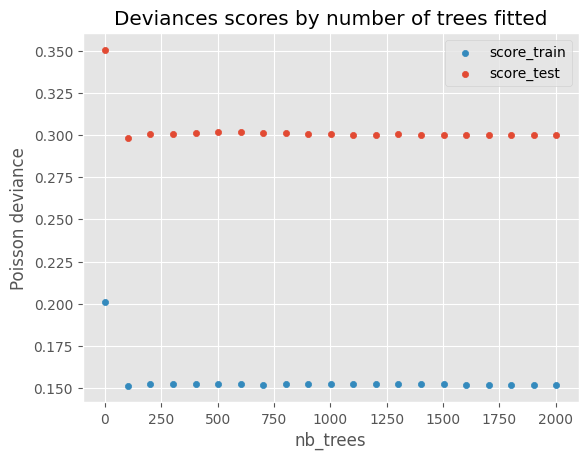

In [63]:
scores_by_nb_trees_df.plot(x='nb_trees', y=['score_train'], \
                                      kind='scatter',
                                      title='Deviances scores by number of trees fitted',
                                       label='score_train',
                           s=20
                                     )
plt.scatter(scores_by_nb_trees_df.nb_trees, scores_by_nb_trees_df.score_test, label='score_test', s=20)
plt.ylabel('Poisson deviance')
plt.legend()
plt.show()

### 2.1 Random Forest - No optimization <a name="two-one"></a>

In [64]:
n_estimators = 500
criterion='poisson'
max_depth = 3
RANDOM_STATE=RANDOM_STATE
ccp_alpha=0.0
params_model = {'n_estimators':n_estimators,
                'criterion':criterion,
                'max_depth':max_depth,
                'random_state':RANDOM_STATE,
                'ccp_alpha':ccp_alpha,
               }

In [65]:
RandomForestRegressorLogger = logging_optimizer_decorator_factory(RandomForestRegressor)
rf, results = RandomForestRegressorLogger('rf_without_opt',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                    False,
                                     **params_model)

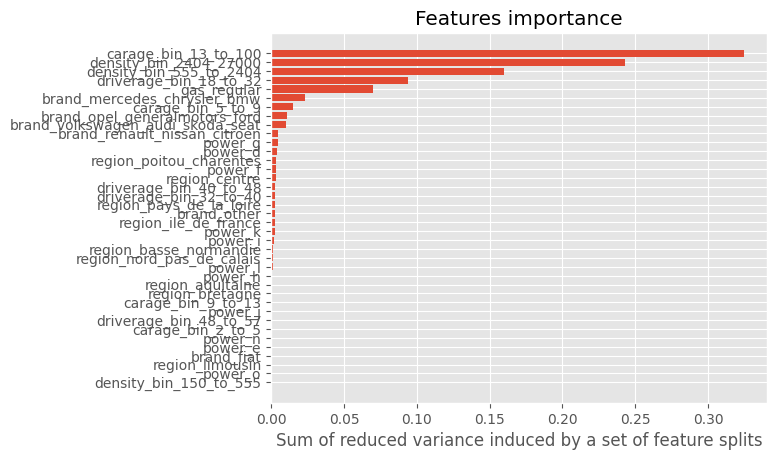

In [66]:
plot_feature_importance_for_tree_based_methods(rf)

In [67]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.3024,0.3012,NaN,0.0057,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0, 'splitter': 'best', 'max_features': 'auto', 'random_state': 42}"
reg_tree_opt_rs_scikit,0.3038,0.3029,0.0035,0.5705,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"
reg_tree_opt_halving_rs_scikit,0.3038,0.3029,0.0613,0.0571,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.3038,0.3029,NaN,0.6403,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 1.0}"
rf_without_opt,0.3019,0.3007,NaN,1.8008,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"


### 2.2 Random Forest - Random Search Scikit Learn optimization <a name="two-two"></a>

In [68]:
param_grid_rf = {'n_estimators':list(np.arange(10, 500, 10)),    
                'max_depth': [7],
               'random_state':[RANDOM_STATE],
              'criterion': ['poisson'],
              'ccp_alpha': list(np.arange(0,0.0003+step, step))
             }
meta_hyperparams = {'estimator':RandomForestRegressor(), 
                    'param_distributions':param_grid_rf,
                    'n_iter':N_ITER_SKLEARN_HYPEROPT,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True
                   }
RandomSearchLogger = logging_optimizer_decorator_factory(RandomizedSearchCV)
rf_opt_rs_scikit, results = RandomSearchLogger('rf_opt_rs_scikit',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     True,
                                    **meta_hyperparams)

In [69]:
rf_opt_rs_scikit_estimator = RandomForestRegressor(**rf_opt_rs_scikit.best_params_)
rf_opt_rs_scikit_estimator.fit(x_train, y_train)

RandomForestRegressor(criterion='poisson', max_depth=7, n_estimators=80,
                      random_state=42)

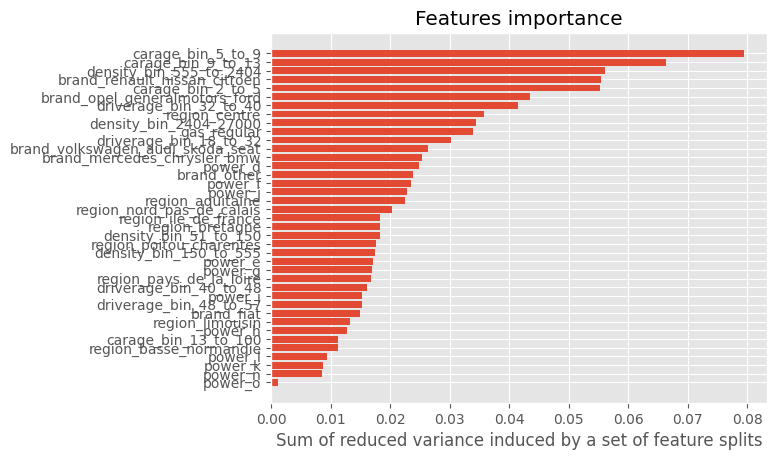

In [70]:
plot_feature_importance_for_tree_based_methods(rf_opt_rs_scikit_estimator)

In [71]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.3024,0.3012,NaN,0.0057,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0, 'splitter': 'best', 'max_features': 'auto', 'random_state': 42}"
reg_tree_opt_rs_scikit,0.3038,0.3029,0.0035,0.5705,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"
reg_tree_opt_halving_rs_scikit,0.3038,0.3029,0.0613,0.0571,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.3038,0.3029,NaN,0.6403,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 1.0}"
rf_without_opt,0.3019,0.3007,NaN,1.8008,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"
rf_opt_rs_scikit,0.2971,0.2990,0.0036,77.6460,"{'random_state': 42, 'n_estimators': 80, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"


### 2.3 Random Forest - Halving Random Search Scikit Learn optimization <a name="two-three"></a>

In [72]:
meta_hyperparams = {'estimator':RandomForestRegressor(), 
                    'param_distributions':param_grid_rf,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True
                   }

In [73]:
HalvingRandomSearchLogger = logging_optimizer_decorator_factory(HalvingRandomSearchCV)
i, has_successfully_ran = 0, False
while i < NB_MAX_ERRORS_FOR_RERUNNING_OPTIMIZATION and not(has_successfully_ran):
    try:
        rf_opt_halving_rs_scikit, results = HalvingRandomSearchLogger('rf_opt_halving_rs_scikit',
                                             x_train, 
                                             y_train, 
                                             x_test, 
                                             y_test, 
                                             exp_train,
                                             exp_test,
                                             True,
                                            **meta_hyperparams)
        has_successfully_ran=True
    except Exception as e:
        print(f'{"-"*20} {i} ITERATION FAILED {"-"*20}')
        print(str(e))
        i+=1

In [74]:
rf_opt_halving_rs_scikit_estimator = RandomForestRegressor(**rf_opt_halving_rs_scikit.best_params_)
rf_opt_halving_rs_scikit_estimator.fit(x_train, y_train)

RandomForestRegressor(criterion='poisson', max_depth=7, n_estimators=230,
                      random_state=42)

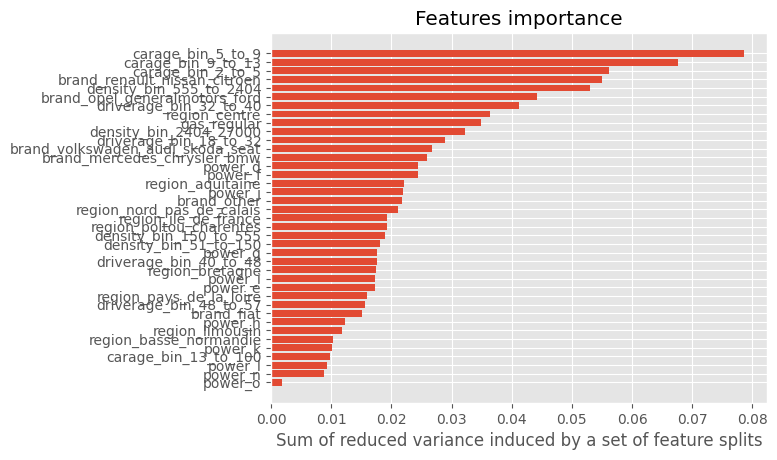

In [75]:
plot_feature_importance_for_tree_based_methods(rf_opt_halving_rs_scikit_estimator)

In [76]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.3024,0.3012,NaN,0.0057,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0, 'splitter': 'best', 'max_features': 'auto', 'random_state': 42}"
reg_tree_opt_rs_scikit,0.3038,0.3029,0.0035,0.5705,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"
reg_tree_opt_halving_rs_scikit,0.3038,0.3029,0.0613,0.0571,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.3038,0.3029,NaN,0.6403,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 1.0}"
rf_without_opt,0.3019,0.3007,NaN,1.8008,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"
rf_opt_rs_scikit,0.2971,0.2990,0.0036,77.6460,"{'random_state': 42, 'n_estimators': 80, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_opt_halving_rs_scikit,0.2970,0.2991,0.0878,3.0096,"{'random_state': 42, 'n_estimators': 230, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"


### 2.4 Random Forest -  Bayesian Mango optimization <a name="two-four"></a>

In [77]:
# @scheduler.parallel(n_jobs=N_JOBS_MANGO_PARALLEL)
def objective_rf(hyperparameters:Dict[str, Any]) -> List[float]:
    global x_train, y_train, x_val, y_val, exp_train, exp_val
    
    results = []
    for hyperparams in hyperparameters:
        model = RandomForestRegressor(**hyperparams)
        model.fit(x_train, y_train)
        pred_val = model.predict(x_val)
        error = mean_poisson_deviance(y_val, pred_val, sample_weight=exp_val)
        results.append(error)
    return results
meta_params = {'param_dict':param_grid_rf,
                'objective':objective_rf,
               'conf_dict':{'num_iteration':N_ITER, 'initial_random':RANDOM_STATE}
              }
logging_mango_optimizer_decorator_factory = LoggingOptimizerMango()
BayesianOptimizerLogger = logging_mango_optimizer_decorator_factory(Tuner)
rf_bayesian_opt_mango, results = BayesianOptimizerLogger('rf_bayesian_opt_mango',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     RandomForestRegressor,
                                    **meta_params)

  0%|          | 0/10 [00:00<?, ?it/s]

In [79]:
pd.DataFrame(results).sort_values(by='dev_poiss_test',ascending=True)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
rf_opt_rs_scikit,0.2971,0.2990,0.0036,77.6460,"{'random_state': 42, 'n_estimators': 80, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_bayesian_opt_mango,0.2971,0.2990,NaN,108.3119,"{'random_state': 42, 'n_estimators': 100, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_opt_halving_rs_scikit,0.2970,0.2991,0.0878,3.0096,"{'random_state': 42, 'n_estimators': 230, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_without_opt,0.3019,0.3007,NaN,1.8008,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"
reg_tree_without_opt,0.3024,0.3012,NaN,0.0057,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0, 'splitter': 'best', 'max_features': 'auto', 'random_state': 42}"
reg_tree_opt_rs_scikit,0.3038,0.3029,0.0035,0.5705,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"
reg_tree_opt_halving_rs_scikit,0.3038,0.3029,0.0613,0.0571,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.3038,0.3029,NaN,0.6403,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 1.0}"


### 2.5 Random Forest - Random Search customized optimization <a name="two-five"></a>

In [80]:
%%script false
def random_forest_fit_func(params_model: Dict[str, Any],
                            x_train: pd.DataFrame,
                            y_train: Union[pd.Series, pd.DataFrame],
                            exp_train: Union[pd.Series, pd.DataFrame]) -> sklearn.ensemble.RandomForestRegressor:
    rf = RandomForestRegressor(**params_model)
    rf.fit(x_train, y_train, sample_weight=exp_train)
    return rf

Couldn't find program: 'false'


In [81]:
%%script false
step = 0.00001
param_grid = {'n_estimators':list(np.arange(10, 500, 10)),    
                'max_depth': list(np.arange(3,8)),
               'random_state':[RANDOM_STATE],
              'criterion': ['poisson'],
              'ccp_alpha': list(np.arange(0,0.0003+step, step))
             }
hyperparams_space = param_grid
model_fit_func = random_forest_fit_func
loss_function = mean_poisson_deviance
limit_time = 180
max_iter = 100
is_debug = False
params_to_record = ['ccp_alpha', 'max_depth', 'n_estimators']
cv_results, best_models = run_hyperopt_for_tree_based_methods(df_train=df_train,
                                   hyperparams_space=param_grid,
                                   model_fit_func=model_fit_func,
                                   loss_function=loss_function,
                                   params_to_record=params_to_record,
                                   exposure_name=exposure_name,
                                   target_name = claim_frequency_name,
                                   limit_time=limit_time,
                                   max_iter=max_iter,
                                   is_debug=False)

Couldn't find program: 'false'


In [82]:
%%script false
sorted_results = cv_results.sort_values(by=['cv_mean_loss', 'cv_std_loss'], ascending=True)
sorted_results

Couldn't find program: 'false'


In [83]:
%%script false
best_result = cv_results.loc[sorted_results.first_valid_index(), ['ccp_alpha', 'max_depth', 'n_estimators', 'cv_std_loss']]
best_result

Couldn't find program: 'false'


In [84]:
%%script false
rf_opt = RandomForestRegressor(criterion='poisson', 
                                         max_depth=best_result.max_depth, 
                                         ccp_alpha=best_result.ccp_alpha, 
                                         n_estimators=best_result.n_estimators, 
                                         random_state=RANDOM_STATE)
rf_opt.fit(x_train, y_train, sample_weight=exp_train)

Couldn't find program: 'false'


In [85]:
%%script false
plot_feature_importance_for_tree_based_methods(rf_opt)

Couldn't find program: 'false'


In [86]:
%%script false
dev_poiss_rf_opt_train = mean_poisson_deviance(y_train, rf_opt.predict(x_train),sample_weight=exp_train)
dev_poiss_rf_opt_test = mean_poisson_deviance(y_test, rf_opt.predict(x_test),sample_weight=exp_test)

results['dev_poiss_train']['rf_opt'] = dev_poiss_rf_opt_train
results['dev_poiss_test']['rf_opt'] = dev_poiss_rf_opt_test
results['cv_std']['rf_opt'] = best_result.cv_std_loss

Couldn't find program: 'false'


In [87]:
pd.DataFrame(results).sort_values(by='dev_poiss_test', ascending=True)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
rf_opt_rs_scikit,0.2971,0.2990,0.0036,77.6460,"{'random_state': 42, 'n_estimators': 80, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_bayesian_opt_mango,0.2971,0.2990,NaN,108.3119,"{'random_state': 42, 'n_estimators': 100, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_opt_halving_rs_scikit,0.2970,0.2991,0.0878,3.0096,"{'random_state': 42, 'n_estimators': 230, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_without_opt,0.3019,0.3007,NaN,1.8008,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"
reg_tree_without_opt,0.3024,0.3012,NaN,0.0057,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0, 'splitter': 'best', 'max_features': 'auto', 'random_state': 42}"
reg_tree_opt_rs_scikit,0.3038,0.3029,0.0035,0.5705,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"
reg_tree_opt_halving_rs_scikit,0.3038,0.3029,0.0613,0.0571,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.3038,0.3029,NaN,0.6403,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 1.0}"


## 3 Gradient Boosting  <a name="three"></a>

### 3.1 Gradient Boosting - No optimization  <a name="three-one"></a>

In [88]:
n_estimators = 500
objective='count:poisson'
monotone_constraints = tuple([0 for _ in range(x_train.shape[1])])
max_depth = 7
learning_rate = 0.01
eta = 0.3
base_score = y_train.mean()
params_model = {'n_estimators':n_estimators,
                'objective':objective,
                'eta':eta,
                #'monotone_constraints':monotone_constraints,
                'max_depth':max_depth,
                'learning_rate':learning_rate,
                'base_score':base_score,
                'seed':RANDOM_STATE
               }

In [89]:
XGBRegressorLogger = logging_optimizer_decorator_factory(xgb.XGBRegressor)
xgb_without_opt, results = XGBRegressorLogger('xgb_without_opt',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                    False,
                                     **params_model)

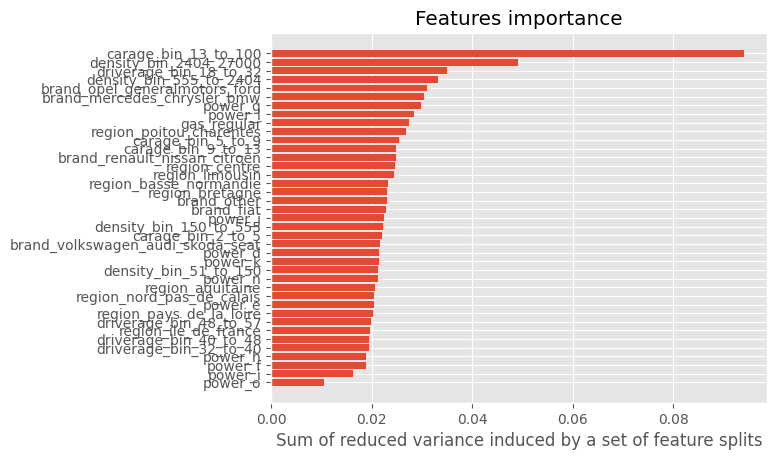

In [90]:
plot_feature_importance_for_tree_based_methods(xgb_without_opt)

In [91]:
pd.DataFrame(results).sort_values(by='dev_poiss_test', ascending=True)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
rf_opt_rs_scikit,0.2971,0.2990,0.0036,77.6460,"{'random_state': 42, 'n_estimators': 80, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_bayesian_opt_mango,0.2971,0.2990,NaN,108.3119,"{'random_state': 42, 'n_estimators': 100, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_opt_halving_rs_scikit,0.2970,0.2991,0.0878,3.0096,"{'random_state': 42, 'n_estimators': 230, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
xgb_without_opt,0.2950,0.2993,NaN,1.2753,"{'n_estimators': 500, 'objective': 'count:poisson', 'eta': 0.3, 'max_depth': 7, 'learning_rate': 0.01, 'base_score': 0.03917224965628057, 'seed': 42}"
rf_without_opt,0.3019,0.3007,NaN,1.8008,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"
reg_tree_without_opt,0.3024,0.3012,NaN,0.0057,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0, 'splitter': 'best', 'max_features': 'auto', 'random_state': 42}"
reg_tree_opt_rs_scikit,0.3038,0.3029,0.0035,0.5705,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"
reg_tree_opt_halving_rs_scikit,0.3038,0.3029,0.0613,0.0571,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.3038,0.3029,NaN,0.6403,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 1.0}"


### 3.2 Gradient Boosting - Random Search Scikit Learn optimization  <a name="three-two"></a>

In [92]:
%%script false
def objective(hyperparameters:Dict[str, Any]) -> List[float]:
    global x_train, y_train, x_val, y_val, exp_train, exp_val
    
    results = []
    for hyperparams in hyperparameters:
        model = xgb.XGBRegressor(**hyperparams)
        model.fit(x_train, y_train)
        pred_val = model.predict(x_val)
        error = mean_poisson_deviance(y_val, pred_val, sample_weight=exp_val)
        results.append(error)
    return results

param_grid_gbm = {'n_estimators':list(np.arange(10, 500, 10)),
                'objective':['count:poisson'],
#                 'ccp_alpha':list(np.arange(0, 1, step)),
                'eta':list(np.arange(0,0.5+step, step)),
                #'monotone_constraints':monotone_constraints,
                'max_depth':list(np.arange(3,8)),
                'learning_rate':[learning_rate],
#                 'base_score':[base_score],
                'seed':[RANDOM_STATE]
               }
meta_params = {'param_dict':param_grid_gbm,
                'objective':objective,
               'conf_dict':{'num_iteration':N_ITER, 'initial_random':RANDOM_STATE}
              }

Couldn't find program: 'false'


In [93]:
%%script false
step = 0.00001
param_grid = {'n_estimators':list(np.arange(10, 500, 10)),
                'objective':['count:poisson'],
#                 'ccp_alpha':list(np.arange(0, 1, step)),
                'eta':list(np.arange(0,0.5+step, step)),
                #'monotone_constraints':monotone_constraints,
                'max_depth':list(np.arange(3,8)),
                'learning_rate':[learning_rate],
#                 'base_score':[base_score],
                'random_state':[RANDOM_STATE]
               }
meta_hyperparams = {'estimator':xgb.XGBRegressor(), 
                    'param_distributions':param_grid,
                    'n_iter':N_ITER_SKLEARN_HYPEROPT,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True
                   }

RandomSearchLogger = logging_optimizer_decorator_factory(RandomizedSearchCV)

Couldn't find program: 'false'


In [94]:
%%script false
xgb_opt_rs_scikit, results = RandomSearchLogger('xgb_opt_rs_scikit',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     True,
                                    **meta_hyperparams)

Couldn't find program: 'false'


In [95]:
%%script false
plot_feature_importance_for_tree_based_methods(xgb_opt_rs_scikit)

Couldn't find program: 'false'


### 3.3 Gradient Boosting - Halving Random Search Scikit Learn optimization  <a name="three-three"></a>

In [96]:
%%script false
meta_hyperparams = {'estimator':GradientBoostingRegressor, 
                    'param_distributions':param_grid,
#                     'n_iter':N_ITER_SKLEARN_HYPEROPT,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True
                   }

Couldn't find program: 'false'


In [97]:
%%script false
HalvingRandomSearchLogger = logging_optimizer_decorator_factory(HalvingRandomSearchCV)
xgb_opt_halving_rs_scikit, results = HalvingRandomSearchLogger('xgb_opt_halving_rs_scikit',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     True,
                                    **meta_hyperparams)

Couldn't find program: 'false'


In [98]:
%%script false
plot_feature_importance_for_tree_based_methods(xgb_opt_halving_rs_scikit)

Couldn't find program: 'false'


In [99]:
%%script false
pd.DataFrame(results)

Couldn't find program: 'false'


### 3.4 Gradient Boosting - Bayesian Mango optimization  <a name="three-four"></a>

In [100]:
# @scheduler.parallel(n_jobs=N_JOBS_MANGO_PARALLEL)
def objective_gbm(hyperparameters:Dict[str, Any]) -> List[float]:
    global x_train, y_train, x_val, y_val, exp_train, exp_val
    
    results = []
    for hyperparams in hyperparameters:
        model = xgb.XGBRegressor(**hyperparams)
        model.fit(x_train, y_train)
        pred_val = model.predict(x_val)
        error = mean_poisson_deviance(y_val, pred_val, sample_weight=exp_val)
        results.append(error)
    return results

param_grid_gbm = {'n_estimators':list(np.arange(10, 500, 10)),
                'objective':['count:poisson'],
#                 'ccp_alpha':list(np.arange(0, 1, step)),
                'eta':list(np.arange(0,0.5+step, step)),
                #'monotone_constraints':monotone_constraints,
                'max_depth':list(np.arange(3,8)),
                'learning_rate':[learning_rate],
#                 'base_score':[base_score],
                'seed':[RANDOM_STATE]
               }
meta_params = {'param_dict':param_grid_gbm,
                'objective':objective_gbm,
               'conf_dict':{'num_iteration':N_ITER, 'initial_random':RANDOM_STATE}
              }
logging_mango_optimizer_decorator_factory = LoggingOptimizerMango()
BayesianOptimizerLogger = logging_mango_optimizer_decorator_factory(Tuner)
xgb_bayesian_opt_mango, results = BayesianOptimizerLogger('xgb_bayesian_opt_mango',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     xgb.XGBRegressor,
                                    **meta_params)

  0%|          | 0/10 [00:00<?, ?it/s]

In [102]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.3024,0.3012,NaN,0.0057,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0, 'splitter': 'best', 'max_features': 'auto', 'random_state': 42}"
reg_tree_opt_rs_scikit,0.3038,0.3029,0.0035,0.5705,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"
reg_tree_opt_halving_rs_scikit,0.3038,0.3029,0.0613,0.0571,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.3038,0.3029,NaN,0.6403,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 1.0}"
rf_without_opt,0.3019,0.3007,NaN,1.8008,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"
rf_opt_rs_scikit,0.2971,0.2990,0.0036,77.6460,"{'random_state': 42, 'n_estimators': 80, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_opt_halving_rs_scikit,0.2970,0.2991,0.0878,3.0096,"{'random_state': 42, 'n_estimators': 230, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_bayesian_opt_mango,0.2971,0.2990,NaN,108.3119,"{'random_state': 42, 'n_estimators': 100, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
xgb_without_opt,0.2950,0.2993,NaN,1.2753,"{'n_estimators': 500, 'objective': 'count:poisson', 'eta': 0.3, 'max_depth': 7, 'learning_rate': 0.01, 'base_score': 0.03917224965628057, 'seed': 42}"
xgb_bayesian_opt_mango,0.3206,0.3217,NaN,27.0547,"{'eta': 0.3, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 490, 'objective': 'count:poisson', 'seed': 42}"


### 3.5 Gradient Boosting - Random Search Customed optimization  <a name="three-five"></a>

In [103]:
x_train.columns

Index(['power_d', 'power_e', 'power_f', 'power_g', 'power_h', 'power_i',
       'power_j', 'power_k', 'power_l', 'power_n', 'power_o', 'brand_fiat',
       'brand_mercedes_chrysler_bmw', 'brand_opel_generalmotors_ford',
       'brand_renault_nissan_citroen', 'brand_volkswagen_audi_skoda_seat',
       'brand_other', 'gas_regular', 'region_aquitaine',
       'region_basse_normandie', 'region_bretagne', 'region_centre',
       'region_ile_de_france', 'region_limousin', 'region_nord_pas_de_calais',
       'region_pays_de_la_loire', 'region_poitou_charentes',
       'driverage_bin_18_to_32', 'driverage_bin_32_to_40',
       'driverage_bin_40_to_48', 'driverage_bin_48_to_57', 'carage_bin_2_to_5',
       'carage_bin_5_to_9', 'carage_bin_9_to_13', 'carage_bin_13_to_100',
       'density_bin_51_to_150', 'density_bin_150_to_555',
       'density_bin_555_to_2404', 'density_bin_2404_27000'],
      dtype='object')

In [104]:
n_estimators = 500
objective='count:poisson'
monotone_constraints = tuple([0 for _ in range(x_train.shape[1])])
max_depth = 7
learning_rate = 0.01
eta = 0.3
base_score = y_train.mean()
params_model = {'n_estimators':n_estimators,
                'objective':objective,
                'eta':eta,
                #'monotone_constraints':monotone_constraints,
                'max_depth':max_depth,
                'learning_rate':learning_rate,
                'base_score':base_score,
                'seed':RANDOM_STATE
               }

In [105]:
gbm = xgb.XGBRegressor(**params_model)
gbm.fit(x_train, y_train, sample_weight=exp_train)

XGBRegressor(base_score=0.03917224965628057, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0.699999988, max_depth=7, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='count:poisson', predictor='auto', random_state=42, ...)

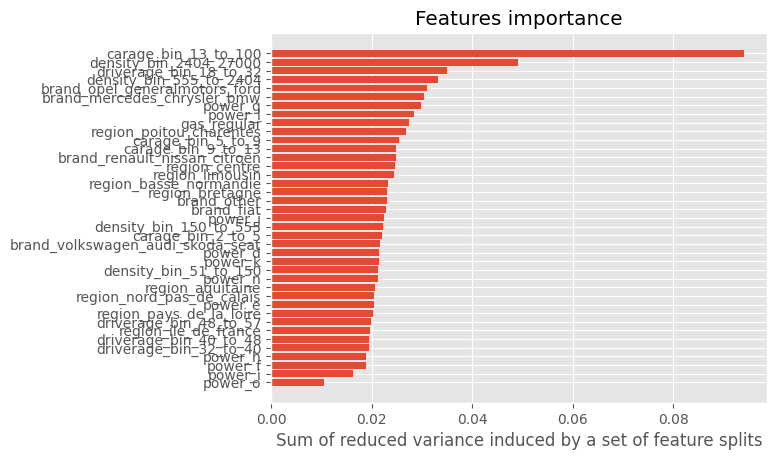

In [106]:
plot_feature_importance_for_tree_based_methods(gbm)

In [107]:
dev_poiss_xgb_train = mean_poisson_deviance(y_train, gbm.predict(x_train),sample_weight=exp_train)
dev_poiss_xgb_test = mean_poisson_deviance(y_test, gbm.predict(x_test),sample_weight=exp_test)

In [109]:
def gradient_boosting_fit_func(params_model: Dict[str, Any],
                            x_train: pd.DataFrame,
                            y_train: Union[pd.Series, pd.DataFrame],
                            exp_train: Union[pd.Series, pd.DataFrame]) -> xgb.XGBRegressor:
    gbm = xgb.XGBRegressor(**params_model)
    gbm.fit(x_train, y_train, sample_weight=exp_train)
    return gbm

In [111]:
step = 0.00001
param_grid = {'n_estimators':list(np.arange(10, 500, 10)),
                'objective':[objective],
                'eta':list(np.arange(0,0.5+step, step)),
                #'monotone_constraints':monotone_constraints,
                'max_depth':list(np.arange(3,8)),
                'learning_rate':[learning_rate],
                'base_score':[base_score],
                'seed':[RANDOM_STATE]
               }
hyperparams_space = param_grid
model_fit_func = gradient_boosting_fit_func
loss_function = mean_poisson_deviance
limit_time = 180
max_iter = 100
is_debug = False
params_to_record = ['max_depth', 'n_estimators', 'eta']
df_train = pd.concat([x_train, y_train, exp_train], axis=1)
start_time = time()
cv_results, best_models = run_hyperopt_for_tree_based_methods(df_train=df_train,
                                   hyperparams_space=param_grid,
                                   model_fit_func=model_fit_func,
                                   loss_function=loss_function,
                                   params_to_record=params_to_record,
                                   exposure_name=exposure_name,
                                   target_name = nb_claims_name,
                                   limit_time=limit_time,
                                   max_iter=max_iter,
                                   is_debug=False)
opt_time_xgb_opt_rs_custom = time() - start_time

In [112]:
sorted_results = cv_results.sort_values(by=['cv_mean_loss', 'cv_std_loss'], ascending=True)
sorted_results

,losses,cv_mean_loss,cv_std_loss,hyperparams,max_depth,n_estimators,eta
0,"[0.30058820810362835, 0.2953194490139738, 0.3047648367550898, 0.30010701780717747, 0.3014081711295696]",0.3004,0.0030,max_depth:7-n_estimators:430-eta:0.27279000000000003,7,430,0.2728


In [113]:
best_result = cv_results.loc[sorted_results.first_valid_index(), ['max_depth', 'n_estimators', 'cv_std_loss', 'eta']]
best_result

max_depth           7
n_estimators      430
cv_std_loss    0.0030
eta            0.2728
Name: 0, dtype: object

In [114]:
objective='count:poisson'
monotone_constraints = tuple([0 for _ in range(x_train.shape[1])])
learning_rate = 0.01
base_score = y_train.mean()
gbm_opt = xgb.XGBRegressor(n_estimators=best_result.n_estimators,
                           objective= objective,
                           max_depth=best_result.max_depth,
                           learning_rate=learning_rate,
                           eta=best_result.eta,
                           base_score=base_score)
gbm_opt.fit(x_train, y_train, sample_weight=exp_train)

XGBRegressor(base_score=0.03917224965628057, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.27279000000000003, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0.699999988, max_depth=7,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=430, n_jobs=0,
             num_parallel_tree=1, objective='count:poisson', predictor='auto',
             random_state=0, ...)

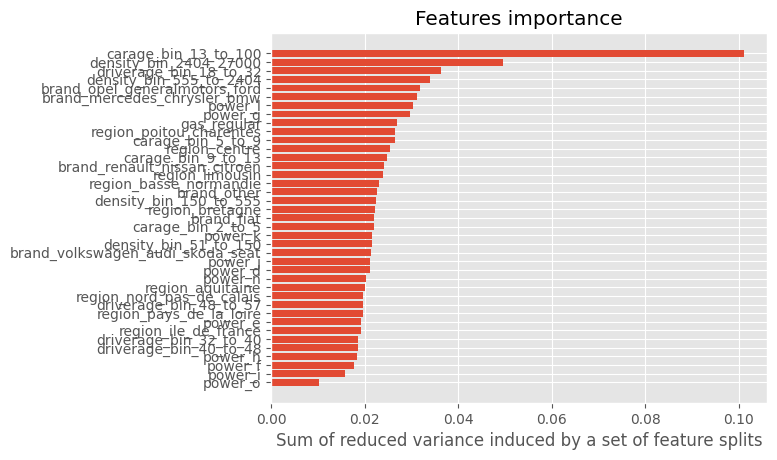

In [115]:
plot_feature_importance_for_tree_based_methods(gbm_opt)

In [116]:
dev_poiss_gbm_opt_train = mean_poisson_deviance(y_train, gbm_opt.predict(x_train),sample_weight=exp_train)
dev_poiss_gbm_opt_test = mean_poisson_deviance(y_test, gbm_opt.predict(x_test),sample_weight=exp_test)

results['dev_poiss_train']['xgb_opt_rs_custom'] = dev_poiss_gbm_opt_train
results['dev_poiss_test']['xgb_opt_rs_custom'] = dev_poiss_gbm_opt_test
results['cv_std']['xgb_opt_rs_custom'] = best_result.cv_std_loss
results['optimization_time']['xgb_opt_rs_custom'] = opt_time_xgb_opt_rs_custom

In [118]:
results_df = pd.DataFrame.from_dict(results)

In [130]:
index_wit_opt = [idx for idx in results_df.index if not 'without' in idx ]
results_df.loc[index_wit_opt, :].sort_values(by=['dev_poiss_test']).style.background_gradient(cmap='coolwarm')

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
rf_opt_rs_scikit,0.297100,0.299000,0.003614,77.645963,"{'random_state': 42, 'n_estimators': 80, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_bayesian_opt_mango,0.297100,0.299000,nan,108.311858,"{'random_state': 42, 'n_estimators': 100, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_opt_halving_rs_scikit,0.297000,0.299100,0.087821,3.009602,"{'random_state': 42, 'n_estimators': 230, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
xgb_opt_rs_custom,0.295714,0.299401,0.003033,nan,nan
reg_tree_opt_rs_scikit,0.303800,0.302900,0.003531,0.570477,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.9500000000000001}"
reg_tree_opt_halving_rs_scikit,0.303800,0.302900,0.061341,0.057094,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.303800,0.302900,nan,0.640310,"{'random_state': 42, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 1.0}"
xgb_bayesian_opt_mango,0.320600,0.321700,nan,27.054706,"{'eta': 0.3, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 490, 'objective': 'count:poisson', 'seed': 42}"


In [120]:
%%script false

#define search spaces and objective functions as done for tuner.

param_space_list = [param_grid_reg_tree, param_grid_rf, param_grid_gbm]
objective_list = [objective_reg_tree, objective_rf, objective_gbm]

metatuner = MetaTuner(param_space_list, objective_list)

results = metatuner.run()

print('best_objective:',results['best_objective'])
print('best_params:',results['best_params'])
print('best_objective_fid:',results['best_objective_fid'])

Couldn't find program: 'false'


*** *Conclusion ****

For the pure ML models, it seems that hte random forest models when optimized with random searches and bayesian optimization reaches similar performance.

It should be noted that, we did not parallelize the jobs to stay fair with respect to the Scikit learn optimization time but both scikit-learn and mango enables job parallelization when running the hyperparameter optimization.